In [1]:
# Python specific imports that will make our job easier and our code prettier
from collections import namedtuple
from functools import partial
# import time
# from tqdm.auto import trange, tqdm

# JAX specific imports that we will use to code the logic
import jax.numpy as jnp
import jax.scipy as jsc
from jax.lax import scan
from jax import random
import jax
import matplotlib.pyplot as plt
import jax.random as random
import matplotlib.pyplot as plt
from jax.scipy.linalg import cho_factor, cho_solve
from jax import jit, vmap, lax

In [2]:
def kf(model, observations):
    def body(carry, inputs):
        m, P, loglik = carry
        y = inputs
        Q = model.Pinf - model.A @ model.Pinf @ model.A.T
        m = model.A @ m 
        P = model.A @ P @ model.A.T + Q

        obs_mean = model.H @ m
        S = model.H @ P @ model.H.T + model.R

        K = jsc.linalg.solve(S, model.H @ P, sym_pos=True).T 
        m = m + K @ (y - model.H @ m)
        P = P - K @ S @ K.T

        loglik = -0.5 * jnp.log(2 * jnp.pi) - 0.5 * jnp.log(jnp.linalg.det(S)) \
                  - 0.5 * (y - obs_mean).T @ cho_solve(cho_factor(S), y - obs_mean)

          
        return (m, P, loglik), (m, P, loglik)

    _, (fms, fPs, loglik) = scan(body, (model.m0, model.P0, jnp.zeros((1, 1))), (observations))
    loglik_sum = jnp.sum(loglik)
    return fms, fPs, loglik_sum

def ks(model, ms, Ps):
    def body(carry, inputs):
        m, P = inputs
        sm, sP = carry
        Q = model.Pinf - model.A @ model.Pinf @ model.A.T

        pm = model.A @ m 
        pP = model.A @ P @ model.A.T + Q

        C = jsc.linalg.solve(pP, model.A @ P, sym_pos=True).T  #
        
        sm = m + C @ (sm - pm)
        sP = P + C @ (sP - pP) @ C.T
        return (sm, sP), (sm, sP)

    _, (sms, sPs) = scan(body, (ms[-1], Ps[-1]), (ms[:-1], Ps[:-1]), reverse=True)
    sms = jnp.append(sms, jnp.expand_dims(ms[-1], 0), 0)
    sPs = jnp.append(sPs, jnp.expand_dims(Ps[-1], 0), 0)
    return sms, sPs

def kfs(model, observations):
    m_f, P_f, _ = kf(model, observations)
    return ks(model, m_f, P_f)


In [3]:
def rotation_matrix(dt, omega):
    """
    Discrete time rotation matrix
    :param dt: step size [1]
    :param omega: frequency [1]
    :return:
        R: rotation matrix [2, 2]
    """
    R = jnp.array([
        [jnp.cos(omega * dt), -jnp.sin(omega * dt)],
        [jnp.sin(omega * dt),  jnp.cos(omega * dt)]
    ])
    return R


def subband_mat32(dt, lam, omega):
    R = rotation_matrix(dt, omega)
    Ri = jnp.block([
        [(1. + dt * lam) * R, dt * R],
        [-dt * lam ** 2 * R,  (1. - dt * lam) * R]
    ])
    return Ri

def make_quasi_periodic(var, ell_p, period, ell_m, dt):
    #hyperparams = softplus(self.hyp) if hyperparams is None else hyperparams
    order=6
    K = jnp.meshgrid(jnp.arange(order + 1), jnp.arange(order + 1))[1]
    
    factorial_mesh_K = jnp.array([[1., 1., 1., 1., 1., 1., 1.],
                                [1., 1., 1., 1., 1., 1., 1.],
                                [2., 2., 2., 2., 2., 2., 2.],
                                [6., 6., 6., 6., 6., 6., 6.],
                                [24., 24., 24., 24., 24., 24., 24.],
                                [120., 120., 120., 120., 120., 120., 120.],
                                [720., 720., 720., 720., 720., 720., 720.]])

    b = jnp.array([[1., 0., 0., 0., 0., 0., 0.],
                [0., 2., 0., 0., 0., 0., 0.],
                [2., 0., 2., 0., 0., 0., 0.],
                [0., 6., 0., 2., 0., 0., 0.],
                [6., 0., 8., 0., 2., 0., 0.],
                [0., 20., 0., 10., 0., 2., 0.],
                [20., 0., 30., 0., 12., 0., 2.]])
    b_fmK_2K = b * (1. / factorial_mesh_K) * (2. ** -K)

    var_p = 1.
    a = b_fmK_2K * ell_p ** (-2. * K) * jnp.exp(-1. / ell_p ** 2.) * var_p
    q2 = jnp.sum(a, axis=0)
    # The angular frequency
    omega = 2 * jnp.pi / period
    # The model
    F_p = jnp.kron(jnp.diag(jnp.arange(order + 1)), jnp.array([[0., -omega], [omega, 0.]]))
    L_p = jnp.eye(2 * (order + 1))
    # Qc_p = np.zeros(2 * (self.N + 1))
    Pinf_p = jnp.kron(jnp.diag(q2), jnp.eye(2))
    H_p = jnp.kron(jnp.ones([1, order + 1]), jnp.array([1., 0.]))
    lam = 3.0 ** 0.5 / ell_m
    F_m = jnp.array([[0.0, 1.0],
                    [-lam ** 2, -2 * lam]])
    L_m = jnp.array([[0],
                    [1]])
    Qc_m = jnp.array([[12.0 * 3.0 ** 0.5 / ell_m ** 3.0 * var]])
    H_m = jnp.array([[1.0, 0.0]])
    Pinf_m = jnp.array([[var, 0.0],
                        [0.0, 3.0 * var / ell_m ** 2.0]])
    # F = np.kron(F_p, np.eye(2)) + np.kron(np.eye(14), F_m)
    F = jnp.kron(F_m, jnp.eye(2 * (order + 1))) + jnp.kron(jnp.eye(2), F_p)
    L = jnp.kron(L_m, L_p)
    Qc = jnp.kron(Qc_m, Pinf_p)
    H = jnp.kron(H_m, H_p)
    # Pinf = np.kron(Pinf_m, Pinf_p)
    Pinf = jnp.block([
        [jnp.kron(Pinf_m, q2[0] * jnp.eye(2)), jnp.zeros([4, 24])],
        [jnp.zeros([4, 4]), jnp.kron(Pinf_m, q2[1] * jnp.eye(2)), jnp.zeros([4, 20])],
        [jnp.zeros([4, 8]), jnp.kron(Pinf_m, q2[2] * jnp.eye(2)), jnp.zeros([4, 16])],
        [jnp.zeros([4, 12]), jnp.kron(Pinf_m, q2[3] * jnp.eye(2)), jnp.zeros([4, 12])],
        [jnp.zeros([4, 16]), jnp.kron(Pinf_m, q2[4] * jnp.eye(2)), jnp.zeros([4, 8])],
        [jnp.zeros([4, 20]), jnp.kron(Pinf_m, q2[5] * jnp.eye(2)), jnp.zeros([4, 4])],
        [jnp.zeros([4, 24]), jnp.kron(Pinf_m, q2[6] * jnp.eye(2))]
    ])

    lam = jnp.sqrt(3.0) / ell_m
    # The angular frequency
    omega = 2 * jnp.pi / period
    harmonics = jnp.arange(order + 1) * omega
    R0 = subband_mat32(dt, lam, harmonics[0])
    R1 = subband_mat32(dt, lam, harmonics[1])
    R2 = subband_mat32(dt, lam, harmonics[2])
    R3 = subband_mat32(dt, lam, harmonics[3])
    R4 = subband_mat32(dt, lam, harmonics[4])
    R5 = subband_mat32(dt, lam, harmonics[5])
    R6 = subband_mat32(dt, lam, harmonics[6])
    A = jnp.exp(-dt * lam) * jnp.block([
        [R0, jnp.zeros([4, 24])],
        [jnp.zeros([4, 4]),  R1, jnp.zeros([4, 20])],
        [jnp.zeros([4, 8]),  R2, jnp.zeros([4, 16])],
        [jnp.zeros([4, 12]), R3, jnp.zeros([4, 12])],
        [jnp.zeros([4, 16]), R4, jnp.zeros([4, 8])],
        [jnp.zeros([4, 20]), R5, jnp.zeros([4, 4])],
        [jnp.zeros([4, 24]), R6]
    ])
    return A, H, F, L, Qc, H, Pinf 

In [4]:
var, ell_p, period, ell_m, dt = 1, 1, 1, 1, 1
A, H, F, L, Qc, H, Pinf = make_quasi_periodic(var, ell_p, period, ell_m, dt)

In [5]:
class Params:
    def __init__(self, A, H, Pinf, R, x0, P0):
        self.A = A
        self.Pinf = Pinf
        self.H = H
        self.R = R  
        self.m0 = x0  
        self.P0 = P0  

In [6]:
key = random.PRNGKey(0)

x = jnp.linspace(0, 100, 100)
y = (jnp.cos(0.04*x+0.33*jnp.pi) * jnp.sin(0.2*x))  + 0.1 * random.normal(key, (100,))

R = jnp.array([[0.1]])
dim = A.shape[0]
print(dim)
x_0 = jnp.zeros(dim).reshape(-1, 1)
P_0 = jnp.eye(dim)*0.1
model = Params(A, H, Pinf, R, x_0, P_0)


28


/var/folders/hz/t56xk_lx0fxb7x_g7tl62kh80000gp/T/ipykernel_36744/301591854.py:12: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  K = jsc.linalg.solve(S, model.H @ P, sym_pos=True).T
/var/folders/hz/t56xk_lx0fxb7x_g7tl62kh80000gp/T/ipykernel_36744/301591854.py:35: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  C = jsc.linalg.solve(pP, model.A @ P, sym_pos=True).T  #


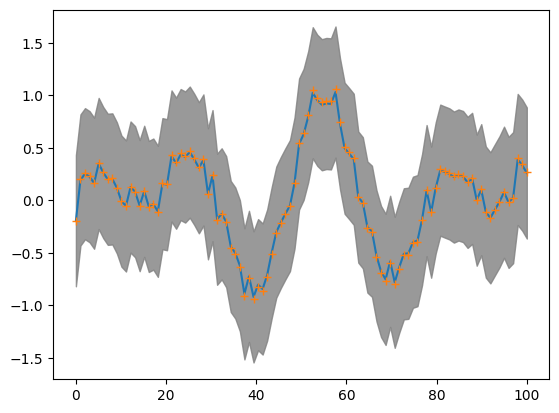

In [7]:
m, P_s = kfs(model, y)
m = jnp.einsum('bkj,jk->bj', m, model.H)
P = jnp.einsum('ijk,jl,kl->il', P_s, model.H.T, model.H.T)

lower = m - 2*jnp.sqrt(P)
upper = m + 2*jnp.sqrt(P)

plt.plot(x, m)
plt.plot(x, y,linestyle='', marker='+')
plt.fill_between(x, jnp.squeeze(lower), jnp.squeeze(upper), alpha=0.8, color='grey')



In [8]:
import jax
import jax.numpy as jnp
import optax

num_epochs = 8500
dt = 1
# Define your model and loss function here
# ...

# Define your optimizer
learning_rate = 0.001
optimizer = optax.adam(learning_rate)

# Initialize your model parameters and optimizer state
params = {'ell_p': jnp.array(1.0),'period': jnp.array(1.0),'ell_m': jnp.array(1.0),'var': jnp.array(1.0),'sigma': jnp.array(1.0)}
opt_state = optimizer.init(params)

def loss(params, y):
    #A, H, F, L, Qc, H, Pinf = make_mat32(params['ell'],params['var'], 1.0)
    A, H, F, L, Qc, H, Pinf = make_quasi_periodic(params['var'], params['ell_p'], params['period'], params['ell_m'], dt)
    
    model = Params(A, H, Pinf, params['sigma'], x_0, P_0)
    m_kf, P_kf, loglik = kf(model, y)
    return -loglik

# Define your training step function
@jax.jit
def train_step(params, opt_state, y):
    # Compute the loss and gradients
    loss_value, grads = jax.value_and_grad(loss)(params, y)

    # Update the optimizer state
    updates, opt_state = optimizer.update(grads, opt_state)

    # Update the model parameters
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss_value

# Define your training loop
for epoch in range(num_epochs):
    # Execute a training step
    params, opt_state, value = train_step(params, opt_state, y)

    # Print the loss at the end of each epoch
    print(f"Epoch {epoch+1}, Loss: {value:.4f}")

/var/folders/hz/t56xk_lx0fxb7x_g7tl62kh80000gp/T/ipykernel_36744/301591854.py:12: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  K = jsc.linalg.solve(S, model.H @ P, sym_pos=True).T


Epoch 1, Loss: 173.8707
Epoch 2, Loss: 173.7611
Epoch 3, Loss: 173.6515
Epoch 4, Loss: 173.5419
Epoch 5, Loss: 173.4324
Epoch 6, Loss: 173.3229
Epoch 7, Loss: 173.2135
Epoch 8, Loss: 173.1040
Epoch 9, Loss: 172.9946
Epoch 10, Loss: 172.8853
Epoch 11, Loss: 172.7760
Epoch 12, Loss: 172.6667
Epoch 13, Loss: 172.5575
Epoch 14, Loss: 172.4483
Epoch 15, Loss: 172.3392
Epoch 16, Loss: 172.2301
Epoch 17, Loss: 172.1210
Epoch 18, Loss: 172.0119
Epoch 19, Loss: 171.9030
Epoch 20, Loss: 171.7940
Epoch 21, Loss: 171.6851
Epoch 22, Loss: 171.5763
Epoch 23, Loss: 171.4674
Epoch 24, Loss: 171.3587
Epoch 25, Loss: 171.2499
Epoch 26, Loss: 171.1412
Epoch 27, Loss: 171.0326
Epoch 28, Loss: 170.9240
Epoch 29, Loss: 170.8154
Epoch 30, Loss: 170.7069
Epoch 31, Loss: 170.5984
Epoch 32, Loss: 170.4900
Epoch 33, Loss: 170.3816
Epoch 34, Loss: 170.2732
Epoch 35, Loss: 170.1648
Epoch 36, Loss: 170.0565
Epoch 37, Loss: 169.9482
Epoch 38, Loss: 169.8399
Epoch 39, Loss: 169.7315
Epoch 40, Loss: 169.6232
Epoch 41,

/var/folders/hz/t56xk_lx0fxb7x_g7tl62kh80000gp/T/ipykernel_36744/301591854.py:12: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  K = jsc.linalg.solve(S, model.H @ P, sym_pos=True).T
/var/folders/hz/t56xk_lx0fxb7x_g7tl62kh80000gp/T/ipykernel_36744/301591854.py:35: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  C = jsc.linalg.solve(pP, model.A @ P, sym_pos=True).T  #


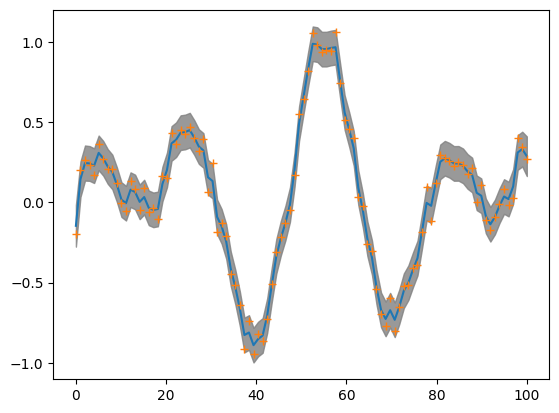

In [9]:
A, H, F, L, Qc, H, Pinf = make_quasi_periodic(params['var'], params['ell_p'], params['period'], params['ell_m'], dt)

model = Params(A, H, Pinf, params['sigma'], x_0, P_0)

m, P_s = kfs(model, y)

m = jnp.einsum('bkj,jk->bj', m, model.H)
P = jnp.einsum('ijk,jl,kl->il', P_s, model.H.T, model.H.T)

lower = m - 2*jnp.sqrt(P)
upper = m + 2*jnp.sqrt(P)


plt.plot(x, m)
plt.plot(x, y,linestyle='', marker='+')
plt.fill_between(x, jnp.squeeze(lower), jnp.squeeze(upper), alpha=0.8, color='grey')